# Modulated noise

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology,lensing


In [2]:
# We define the geometry
shape,wcs,modlmap,cc,mgen = maps.flat_sim(deg=10.,px=1.0,lmax=6000,lensed=True,pol=False)

Generating theory Cls...


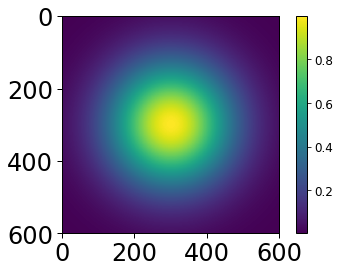

In [31]:
# Let's create a mock hit map
# The object we work with is "div"
# This is inverse variance, and is the output of enki
# 1/div ~ power
# => sqrt(1/div) modulates power in a map
# How is div related to hits?
# Hits ~ time
# sqrt(var) ~ 1/sqrt(time)
# div ~ time
# div ~ Hits
# So div and Hits (output of ninkasi) should be interchangeable
modrmap = enmap.modrmap(shape,wcs)
sigma = 2.0*np.pi/180.
div = np.exp(-modrmap**2./2./sigma**2.)
io.plot_img(div)

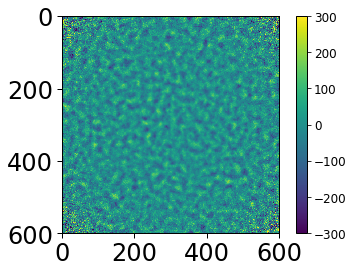

In [33]:
fc = maps.FourierCalc(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
uk_arcmin = 10.
lknee = 500
alpha = -4
nfunc = lambda x: cosmology.white_noise_with_atm_func(x,uk_arcmin,lknee,alpha,dimensionless=False,TCMB=2.7255e6)
ps_noise = nfunc(ells).reshape((1,1,ells.size))
ngen = maps.MapGen(shape,wcs,ps_noise)

def get_sim(splits=1):
    # the CMB is common to all splits
    cmb = mgen.get_map()
    cmb -= cmb.mean()
    
    # Power in noise of n splits is n times larger than that of full map
    # So we bump up the modulation by this factor
    div_each = div/splits
    obs = []
    for i in range(splits):
        nmap = ngen.get_map()
        nmap -= nmap.mean()
        
        # We modulate the power by div
        nmap /= np.sqrt(div_each)
        obs.append ( cmb+nmap )
    return obs

cmask = maps.mask_kspace(shape,wcs,lmin=500)
obs =get_sim()[0]

io.plot_img( maps.filter_map(obs,cmask),lim=300)

f = lambda x: maps.filter_map(x,cmask)

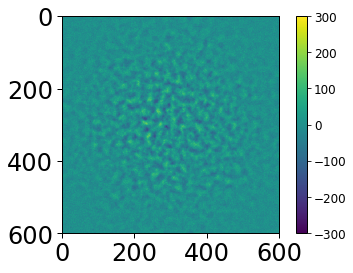

In [34]:
io.plot_img(maps.filter_map(obs,cmask)*np.sqrt(div),lim=300) # Show the "flattened" map

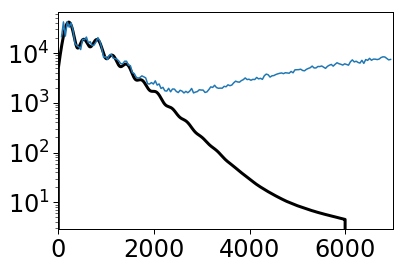

In [35]:
# Plot total power of full CMB map

ellmax = 7000
bin_edges = np.arange(50,ellmax,40)
cents,p1d = maps.binned_power(obs,bin_edges,fc=fc,modlmap=modlmap)
#print(p1d)

pl = io.Plotter(yscale='log')
pl.add(ells,ells**2.*cc.theory.lCl('TT',ells),color='k',lw=3)
pl.add(cents,p1d*cents**2.)
pl._ax.set_xlim(0,ellmax)
#pl._ax.set_ylim(1e3,8e4)
pl.done()

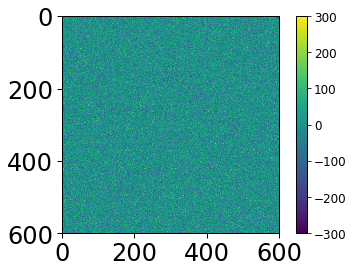

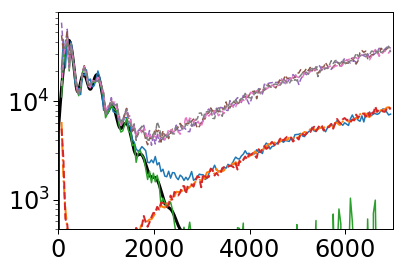

In [36]:
# Now we imagine we had 4 splits of the data (these have modulated noise)
splits = get_sim(4)

# We calculate the noise power from splits, and cross-power and bin it
n2d,cross = maps.noise_from_splits(splits,fc)
binner = stats.bin2D(modlmap,bin_edges)
cents,n1d = binner.bin(n2d)
cents,cross1d = binner.bin(cross)

# We generate a sim using this noise power. It is not modulated.
nmodgen = maps.MapGen(shape[-2:],wcs,n2d.reshape((1,1,shape[0],shape[1])))
nsim = nmodgen.get_map()
io.plot_img(f(nsim),lim=300.)
cents,p1dnsim = maps.binned_power(nsim,bin_edges,fc=fc,modlmap=modlmap)

pl = io.Plotter(yscale='log')
pl.add(ells,ells**2.*cc.theory.lCl('TT',ells),color='k',lw=3)
pl.add(cents,p1d*cents**2.)
pl.add(cents,n1d*cents**2.,ls="-.",lw=2)
pl.add(cents,cross1d*cents**2.)
pl.add(cents,p1dnsim*cents**2.,ls="--",lw=2)


for split in splits:
    cents,p1ds = maps.binned_power(split,bin_edges,fc=fc,modlmap=modlmap)
    pl.add(cents,p1ds*cents**2.,ls="--")

pl._ax.set_xlim(0,ellmax)
pl._ax.set_ylim(5e2,8e4)
pl.done()

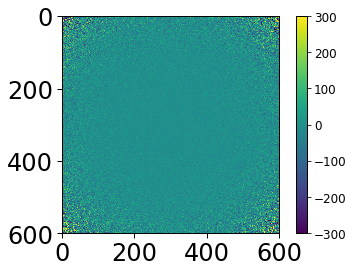

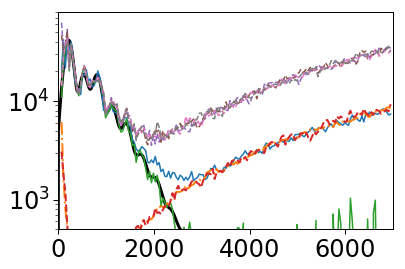

In [37]:
# We saw above that if the noise power is modulated, just calculating noise from splits without any weighting gives an answer that agrees with autopower of map at high ell, if that autopower is calculated with no weighting. We also saw that an unmodulated noise sim generated using this power has the right noise power.

# Let's generate a modulated sim. For this, we first flatten the splits before calculating noise power.

splitsSim = [x*np.sqrt(div) for x in get_sim(4)]
n2dSim,_ = maps.noise_from_splits(splitsSim,fc)

# Then use the flattened noise PSD to generate a sim, and modulate it
nmodgen = maps.MapGen(shape[-2:],wcs,n2dSim.reshape((1,1,shape[0],shape[1])))
nsim = nmodgen.get_map()
nsim = nsim/np.sqrt(div)
io.plot_img(f(nsim),lim=300.)
cents,p1dnsim = maps.binned_power(nsim,bin_edges,fc=fc,modlmap=modlmap)

cents,p1d = maps.binned_power(obs,bin_edges,fc=fc,modlmap=modlmap)

pl = io.Plotter(yscale='log')
pl.add(ells,ells**2.*cc.theory.lCl('TT',ells),color='k',lw=3)
pl.add(cents,p1d*cents**2.)
pl.add(cents,n1d*cents**2.,ls="-.",lw=2)
pl.add(cents,cross1d*cents**2.)
pl.add(cents,p1dnsim*cents**2.,ls="--",lw=2)

for split in splits:
    cents,p1ds = maps.binned_power(split,bin_edges,fc=fc,modlmap=modlmap)
    pl.add(cents,p1ds*cents**2.,ls="--")

pl._ax.set_xlim(0,ellmax)
pl._ax.set_ylim(5e2,8e4)
pl.done()

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


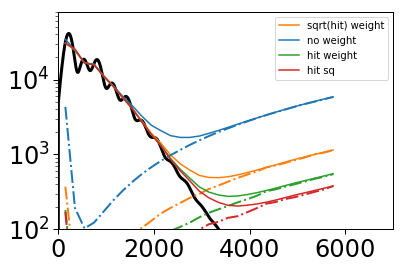

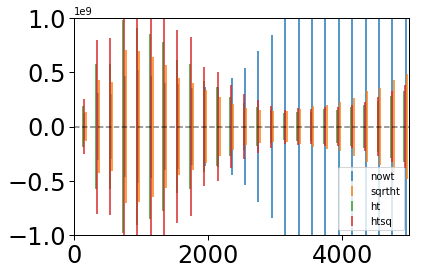

In [64]:
w2 = np.mean(np.sqrt(div)**2.)
w2Alt = np.mean(div**2.)
w2Ext = np.mean(div**4.)

st = stats.Stats()
Nsims = 200
Lbin_edges = np.arange(50,6000,200)
Lbinner = stats.bin2D(modlmap,Lbin_edges)
for i in range(Nsims):
    if (i+1)%10==0: print(i+1)
    obs =get_sim()[0]
    Lcents,p1d = maps.binned_power(obs,Lbin_edges,fc=fc,modlmap=modlmap)
    Lcents,p1dL = maps.binned_power(obs*np.sqrt(div),Lbin_edges,fc=fc,modlmap=modlmap)
    p1dL /= w2
    Lcents,p1dLAlt = maps.binned_power(obs*(div),Lbin_edges,fc=fc,modlmap=modlmap)
    p1dLAlt /= w2Alt
    Lcents,p1dLExt = maps.binned_power(obs*(div**2.),Lbin_edges,fc=fc,modlmap=modlmap)
    p1dLExt /= w2Ext
    
    
    splits = get_sim(4)
    n2d,cross = maps.noise_from_splits(splits,fc)
    Lcents,n1d = Lbinner.bin(n2d)
    Lcents,c1d = Lbinner.bin(cross)

    splitsMod = [x*np.sqrt(div) for x in splits]
    n2dMod,cross = maps.noise_from_splits(splitsMod,fc)
    Lcents,n1dMod = Lbinner.bin(n2dMod/w2)
    Lcents,c1dMod = Lbinner.bin(cross/w2)


    splitsModAlt = [x*(div) for x in splits]
    n2dModAlt,cross = maps.noise_from_splits(splitsModAlt,fc)
    Lcents,n1dModAlt = Lbinner.bin(n2dModAlt/w2Alt)
    Lcents,c1dModAlt = Lbinner.bin(cross/w2Alt)


    splitsModExt = [x*(div**2) for x in splits]
    n2dModExt,cross = maps.noise_from_splits(splitsModExt,fc)
    Lcents,n1dModExt = Lbinner.bin(n2dModExt/w2Ext)
    Lcents,c1dModExt = Lbinner.bin(cross/w2Ext)
   
    
    st.add_to_stats("nowt",p1d)
    st.add_to_stats("sqrtht",p1dL)
    st.add_to_stats("ht",p1dLAlt)
    st.add_to_stats("htsq",p1dLExt)
    
    st.add_to_stats("nnowt",n1d)
    st.add_to_stats("nsqrtht",n1dMod)
    st.add_to_stats("nht",n1dModAlt)
    st.add_to_stats("nhtsq",n1dModExt)
    
    st.add_to_stats("cnowt",c1d)
    st.add_to_stats("csqrtht",c1dMod)
    st.add_to_stats("cht",c1dModAlt)
    st.add_to_stats("chtsq",c1dModExt)
        
    
st.get_stats()

p1d = st.stats["nowt"]['mean']
p1dL = st.stats["sqrtht"]['mean']
p1dLAlt = st.stats["ht"]['mean']
p1dLExt = st.stats["htsq"]['mean']

n1d = st.stats["nnowt"]['mean']
n1dL = st.stats["nsqrtht"]['mean']
n1dLAlt = st.stats["nht"]['mean']
n1dLExt = st.stats["nhtsq"]['mean']

Ep1d = st.stats["cnowt"]['err']
Ep1dL = st.stats["csqrtht"]['err']
Ep1dLAlt = st.stats["cht"]['err']
Ep1dLExt = st.stats["chtsq"]['err']

    

pl = io.Plotter(yscale='log')
pl.add(ells,ells**2.*cc.theory.lCl('TT',ells),color='k',lw=3)
pl.add(Lcents,p1dL*Lcents**2.,color="C1",label="sqrt(hit) weight")
pl.add(Lcents,p1d*Lcents**2.,color="C0",label="no weight")
pl.add(Lcents,n1d*Lcents**2.,ls="-.",lw=2,color="C0")
pl.add(Lcents,n1dMod*Lcents**2.,ls="-.",lw=2,color="C1")
pl.add(Lcents,n1dModAlt*Lcents**2.,ls="-.",lw=2,color="C2")
pl.add(Lcents,p1dLAlt*Lcents**2.,color="C2",label="hit weight")
pl.add(Lcents,n1dModExt*Lcents**2.,ls="-.",lw=2,color="C3")
pl.add(Lcents,p1dLExt*Lcents**2.,color="C3",label="hit sq")

pl._ax.set_xlim(0,ellmax)
pl._ax.set_ylim(1e2,8e4)
pl.legend(loc='upper right')
pl.done()


pl = io.Plotter()
pl.add_err(Lcents,Lcents*0.,yerr=Ep1d*Lcents**4.,label="nowt")#,alpha=0.5)
pl.add_err(Lcents+20,Lcents*0.,yerr=Ep1dL*Lcents**4.,label="sqrtht")#,alpha=0.5)
pl.add_err(Lcents-20,Lcents*0.,yerr=Ep1dLAlt*Lcents**4.,label="ht")#,alpha=0.5)
pl.add_err(Lcents-10,Lcents*0.,yerr=Ep1dLExt*Lcents**4.,label="htsq")#,alpha=0.5)

pl._ax.set_xlim(0,5000)
pl._ax.set_ylim(-1e9,+1e9)

pl.hline()
pl.legend(loc = 'lower right')
pl.done()

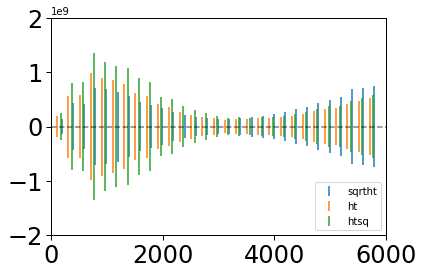

In [66]:
pl = io.Plotter()
#pl.add_err(Lcents-20,Lcents*0.,yerr=Ep1d*Lcents**4.,label="nowt")#,alpha=0.5)
pl.add_err(Lcents+40,Lcents*0.,yerr=Ep1dL*Lcents**4.,label="sqrtht")#,alpha=0.5)
pl.add_err(Lcents-40,Lcents*0.,yerr=Ep1dLAlt*Lcents**4.,label="ht")#,alpha=0.5)
pl.add_err(Lcents+20,Lcents*0.,yerr=Ep1dLExt*Lcents**4.,label="htsq")#,alpha=0.5)

pl._ax.set_xlim(0,6000)
pl._ax.set_ylim(-2e9,+2e9)

pl.hline()
pl.legend(loc = 'lower right')
pl.done()

In [ ]:
# Correct map weighting seems to be sqrt(div) 